
# Assignment-5: Apply Logistic Regression On Amazon Fine Food Reviews DataSet 

## Introduction 

(i).Logistic regression is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal, ordinal, interval or ratio-level independent variables.

(ii).It's name is Regression but actually it is classification algorithm.

## Objective

To Predict the Polarity of Amazon Fine Food Review Using Logistic Regression Algorithm.

## Importing All Required Library

In [1]:
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression 


from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pickle

from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")

C:\Users\User\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Importing Amazon Fine Food Review  Dataset

In [2]:
if os.path.isfile("final.sqlite"):
    conn=sqlite3.connect("final.sqlite")
    Data=pd.read_sql_query("select * from Logistic_Regression_Data where Score!=3",conn)
    conn.close()
else :
    print("Error Importing the file")

In [3]:
# Printing some data of DataFrame

Data['Score'].value_counts()

1    126413
0     23587
Name: Score, dtype: int64

## Information About DataSet

In [4]:
print("\nNumber of Reviews: ",Data["Text"].count())
print("\nNumber of Users: ",len(Data["UserId"].unique())) # Unique returns 1-D array of unique values of DataFrame.
print("\nNumber of Products: ",len(Data["ProductId"].unique()))
print("\nShape of Data: ", Data.shape)
print("\nColumn Name of DataSet : ",Data.columns)
print("\n\nNumber of Attributes/Columns in data: 12") 
print("\nNumber of Positive Reviews : ", Data['Score'].value_counts()[1])
print("\nNumber of Negative Reviews : ", Data['Score'].value_counts()[0])


Number of Reviews:  150000

Number of Users:  115887

Number of Products:  42869

Shape of Data:  (150000, 13)

Column Name of DataSet :  Index(['level_0', 'index', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'CleanedText'],
      dtype='object')


Number of Attributes/Columns in data: 12

Number of Positive Reviews :  126413

Number of Negative Reviews :  23587


In [5]:
print("\nNumber of Reviews: ",Data["Text"].count())


Number of Reviews:  150000


## Attribute Information About DataSet

1.Id - A unique value starts from 1



2.ProductId - A unique identifier for the product



3.UserId - A unqiue identifier for the user



4.ProfileName - Name of user profile 



5.HelpfulnessNumerator - Number of users who found the review helpful



6.HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not



7.Score - Rating 0 or 1



8.Time - Timestamp for the review



9.Summary - Brief summary of the review



10.Text - Text of the review



11.Cleaned Text - Text that only alphabets

In [6]:
# Sorting on the basis of Time Parameter
Data.sort_values('Time',inplace=True)

In [7]:
Y = Data['Score'].values
X = Data['CleanedText'].values

## Splitting DataSet into Train and Test Data

In [8]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=Flase): this is for time series split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33,shuffle=False) # this is random splitting

print("Shape of Train and Test Dataset for 50k points")
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

Shape of Train and Test Dataset for 50k points
(100500,) (100500,)
(49500,) (49500,)


## Defining Some Function

###  Train Data Confusion Matrix Plot

In [9]:
def trainconfusionmatrix(model,X_train,y_train):
    print("Confusion Matrix for Train set")
    cm=confusion_matrix(y_train, model.predict(X_train))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Train Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Test Data Confusion Matrix Plot

In [10]:
def testconfusionmatrix(model,X_test,y_test):
    print("Confusion Matrix for Test set")
    cm=confusion_matrix(y_test, model.predict(X_test))
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Test Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### ROC-AUC Curve Plot

In [11]:
def plot_auc_roc(model,X_train,X_test,y_train,y_test):
    train_fpr, train_tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
    plt.legend()
    plt.xlabel("Hyperameter (C)")
    plt.ylabel("AUC")
    plt.title("ROC CURVE PLOTS")
    plt.show()

### Error Plot

In [12]:
def plot(gsv):
    
    Res=gsv.cv_results_
    cv_auc=[(1-x) for x in Res['mean_test_score']]
    train_auc = [(1-x) for x in Res['mean_train_score']]
            
    x1=[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]       
    log_c= [math.log10(x) for x in x1]        
    
   
    plt.xlabel("Hyperparameter (Log(C))",fontsize=15)
    plt.ylabel("Missclassification Error",fontsize=15)
    plt.title('Misclassification Error v/s C',fontsize=15)
    plt.plot(log_c,cv_auc,label="Cross-Validation")
    plt.plot(log_c,train_auc,label="Train")
    plt.legend()
    plt.show()
    

### GridSearchCV

In [13]:
def Grid_SearchCV(X_train,Y_train,regularisation_parameter):
    
    param_grid = {'C':[10000,5000,1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':[regularisation_parameter]} 
    tscv = TimeSeriesSplit(n_splits=10)
    LR = LogisticRegression(class_weight='balanced')
    
    gsv=GridSearchCV(LR,param_grid,cv=tscv,verbose=1,scoring='roc_auc')
    gsv.fit(X_train,Y_train)
    
    return gsv

### 30 Informative Feature

In [14]:
 def show_30_informative_feature(vectorizer,model,n=30):
        
        
    Weights_Index = model.coef_[0].argsort()
    length = len(Weights_Index)
    # For Negative Class
    neg_class=Weights_Index[:30]
    
    neg_feat=[vectorizer.get_feature_names()[x] for x in neg_class]
    neg_prob=[model.coef_[0][x] for x in neg_class]
    
    neg_zip=list(zip(neg_feat,neg_prob))
    neg_zip.sort()
    
    # For Positive Class 
    pos_class =  Weights_Index[-30:]
    
    pos_feat=[vectorizer.get_feature_names()[x] for x in pos_class]
    pos_prob=[model.coef_[0][x] for x in pos_class]
    pos_zip=list(zip(pos_feat,pos_prob))
    pos_zip.sort()
    
    top=zip(pos_zip,neg_zip)
    
    print("{0:20}{1:55}{2:20}".format("S.N","Positive","Negative"))
    print("_"*90)
    i=1
    for (fn_1,coef_1), (fn_2,coef_2) in top:
        print("%d.\t\t%.3f\t%-30s\t\t%.3f\t%s" % (i,coef_1, fn_1, coef_2, fn_2))
        i+=1
    
    

## Bags of Words Vectorizer

In [15]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_train_bow=preprocessing.normalize(X_train_bow)

X_test_bow = vectorizer.transform(X_test)
X_test_bow=preprocessing.normalize(X_test_bow)

print("Shape of Train and Test Data After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_test_bow.shape, Y_test.shape)

Shape of Train and Test Data After vectorizations
(100500, 37994) (100500,)
(49500, 37994) (49500,)


## Part 1 : Taking L1 as a Regularisation Parameter 

### Finding the best value Of hyperparameter (C or 1/Lambda)

In [18]:
gsv=Grid_SearchCV(X_train_bow,Y_train,'l1')

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed: 23.5min finished


Best HyperParameter:  {'C': 5, 'penalty': 'l1'}
Best Accuracy: 93.25%


### Error-Plot

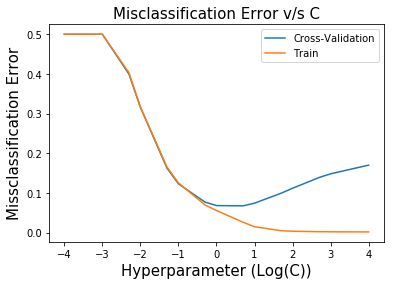

In [45]:
plot(gsv)

### Training the model

In [25]:
Best_Param=gsv.best_params_
C=Best_Param['C']
Penalty = Best_Param['penalty']

Model_Bow=LogisticRegression(C=C,penalty=Penalty,class_weight='balanced')
Model_Bow.fit(X_train_bow,Y_train)

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


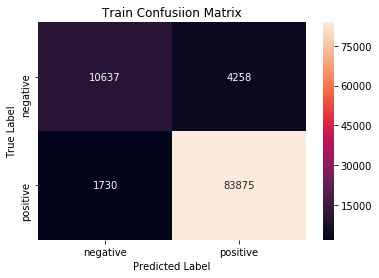

In [26]:
trainconfusionmatrix(Model_Bow,X_train_bow,Y_train)

Confusion Matrix for Test set


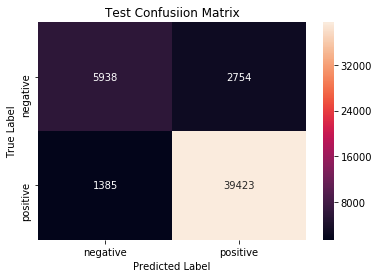

In [27]:
testconfusionmatrix(Model_Bow,X_test_bow,Y_test)

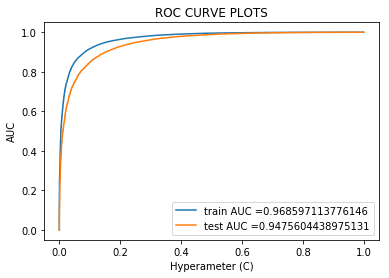

In [28]:
plot_auc_roc(Model_Bow,X_train_bow,X_test_bow,Y_train,Y_test)

In [29]:
print("Classification Report: \n")
y_pred=Model_Bow.predict(X_test_bow)

print(classification_report(Y_test, y_pred))


Classification Report: 

              precision    recall  f1-score   support

           0       0.81      0.68      0.74      8692
           1       0.93      0.97      0.95     40808

   micro avg       0.92      0.92      0.92     49500
   macro avg       0.87      0.82      0.85     49500
weighted avg       0.91      0.92      0.91     49500



### Displaying 30 most informative features

In [30]:
show_30_informative_feature(vectorizer,Model_Bow)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		10.751	addict                        		-15.221	ashtray
2.		14.850	bravo                         		-13.469	assumpt
3.		11.311	cujo                          		-12.922	aw
4.		10.830	delici                        		-21.729	compass
5.		16.410	downsid                       		-15.091	decept
6.		12.746	fascin                        		-12.848	emptor
7.		14.110	filbert                       		-13.724	eyebal
8.		12.056	finest                        		-16.663	feat
9.		12.521	goshoptnt                     		-13.234	heathi
10.		14.539	gripe                         		-14.645	immers
11.		12.249	heal                          		-19.385	leach
12.		12.816	hook                          		-13.507	mediocr
13.		11.312	morsel                        		-12.876	nicknam
14.		13.046	narrow                        		-12.526	nome


## Part 2 : Taking L2 as a Regularisation Parameter

### Finding the best value Of hyperparameter (C or 1/Lambda)

In [46]:
gsv=Grid_SearchCV(X_train_bow,Y_train,'l2')

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed: 18.2min finished


Best HyperParameter:  {'C': 5, 'penalty': 'l2'}
Best Accuracy: 93.73%


### Error Plot

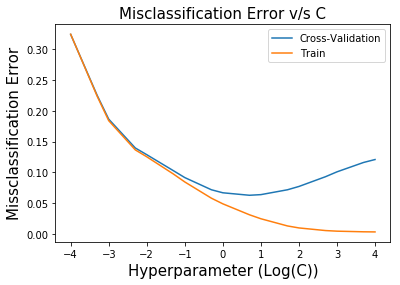

In [47]:
plot(gsv)

### Training the model

In [49]:
Best_Param=gsv.best_params_
C=Best_Param['C']
Penalty = Best_Param['penalty']

Model_Bow=LogisticRegression(C=C,penalty=Penalty,class_weight='balanced')
Model_Bow.fit(X_train_bow,Y_train)

LogisticRegression(C=5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


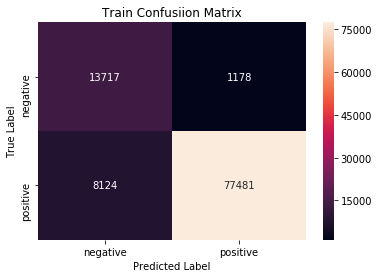

In [50]:
trainconfusionmatrix(Model_Bow,X_train_bow,Y_train)

Confusion Matrix for Test set


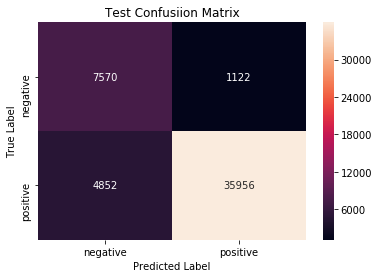

In [51]:
testconfusionmatrix(Model_Bow,X_test_bow,Y_test)

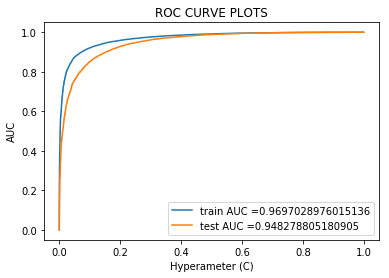

In [52]:
plot_auc_roc(Model_Bow,X_train_bow,X_test_bow,Y_train,Y_test)

In [53]:
print("Classification Report: \n")
y_pred=Model_Bow.predict(X_test_bow)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.61      0.87      0.72      8692
           1       0.97      0.88      0.92     40808

   micro avg       0.88      0.88      0.88     49500
   macro avg       0.79      0.88      0.82     49500
weighted avg       0.91      0.88      0.89     49500



In [54]:
show_30_informative_feature(vectorizer,Model_Bow)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		9.411	addict                        		-11.813	aw
2.		9.014	amaz                          		-8.823	bland
3.		7.990	awesom                        		-8.392	cancel
4.		8.843	beat                          		-8.716	concept
5.		6.319	beauti                        		-10.212	disappoint
6.		7.859	best                          		-9.389	disgust
7.		7.196	complaint                     		-6.951	earth
8.		9.800	delici                        		-7.319	fail
9.		7.950	downsid                       		-7.624	flavorless
10.		5.720	drawback                      		-7.934	gross
11.		8.252	excel                         		-9.971	horribl
12.		6.118	fabul                         		-7.615	ined
13.		7.002	fantast                       		-7.501	mediocr
14.		6.565	glad                          		-6.946	poor
15.		6.892	great       

## TF-IDF Vectorizer

In [30]:
vectorizer_tfidf=TfidfVectorizer()
vectorizer_tfidf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [31]:
X_Train_Tfidf=vectorizer_tfidf.transform(X_train)
X_Train_Tfidf=preprocessing.normalize(X_Train_Tfidf)

X_Test_Tfidf=vectorizer_tfidf.transform(X_test)
X_Test_Tfidf=preprocessing.normalize(X_Test_Tfidf)

In [32]:
print("Shape of Train and Test Data After vectorizations")
print(X_Train_Tfidf.shape, Y_train.shape)
print(X_Test_Tfidf.shape, Y_test.shape)

Shape of Train and Test Data After vectorizations
(100500, 37994) (100500,)
(49500, 37994) (49500,)


## Taking L1 as a Regularisation Parameter

### Finding the best value Of hyperparameter (C or 1/Lambda) 

In [21]:
gsv=Grid_SearchCV(X_Train_Tfidf,Y_train,'l1')

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed: 163.2min finished


Best HyperParameter:  {'C': 1, 'penalty': 'l1'}
Best Accuracy: 93.30%


### Error Plot

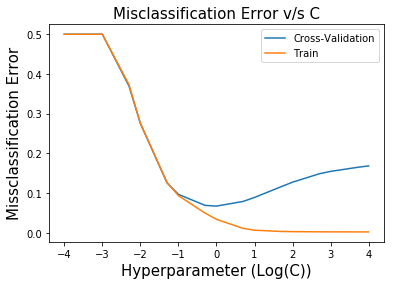

In [22]:
plot(gsv)

### Training the model

In [23]:
Best_Param=gsv.best_params_
C=Best_Param['C']
Penalty = Best_Param['penalty']

Model_Tfidf=LogisticRegression(C=C,penalty=Penalty,class_weight='balanced')
Model_Tfidf.fit(X_train_bow,Y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


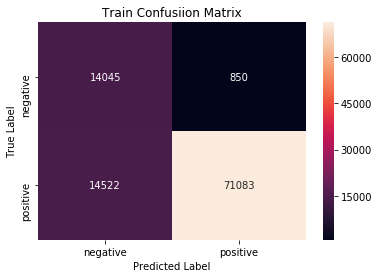

In [24]:
trainconfusionmatrix(Model_Tfidf,X_Train_Tfidf,Y_train)

Confusion Matrix for Test set


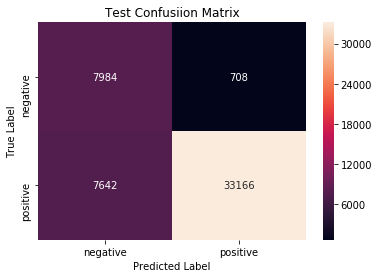

In [25]:
testconfusionmatrix(Model_Tfidf,X_Test_Tfidf,Y_test)

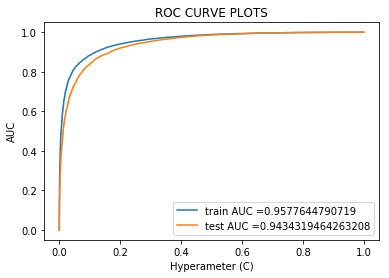

In [26]:
plot_auc_roc(Model_Tfidf,X_Train_Tfidf,X_Test_Tfidf,Y_train,Y_test)

In [27]:
print("Classification Report: \n")
y_pred=Model_Tfidf.predict(X_Test_Tfidf)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.51      0.92      0.66      8692
           1       0.98      0.81      0.89     40808

   micro avg       0.83      0.83      0.83     49500
   macro avg       0.75      0.87      0.77     49500
weighted avg       0.90      0.83      0.85     49500



### Displaying 30 most informative features

In [28]:
show_30_informative_feature(vectorizer_tfidf,Model_Tfidf)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		10.139	addict                        		-13.064	aw
2.		9.406	amaz                          		-9.133	bland
3.		8.423	awesom                        		-10.132	cancel
4.		10.021	beat                          		-10.651	concept
5.		6.980	beauti                        		-7.857	deceiv
6.		7.909	best                          		-9.879	decept
7.		7.294	complaint                     		-10.159	disappoint
8.		9.996	delici                        		-11.139	disgust
9.		11.857	downsid                       		-7.996	drinkabl
10.		8.466	excel                         		-8.134	fail
11.		6.967	fabul                         		-10.004	flavorless
12.		7.052	fantast                       		-8.553	gross
13.		6.808	glad                          		-10.879	horribl
14.		6.894	great                         		-10.254	ined
15.		7.186

## Taking L2 as a Regularisation Parameter

### Finding the best value Of hyperparameter (C or 1/Lambda)

In [29]:
gsv=Grid_SearchCV(X_Train_Tfidf,Y_train,'l2')

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed: 15.0min finished


Best HyperParameter:  {'C': 1, 'penalty': 'l2'}
Best Accuracy: 93.68%


### Error Plot

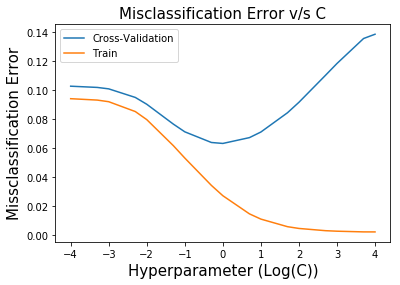

In [30]:
plot(gsv)

### Training the mode

In [31]:
Best_Param=gsv.best_params_
C=Best_Param['C']
Penalty = Best_Param['penalty']

Model_Tfidf=LogisticRegression(C=C,penalty=Penalty,class_weight='balanced')
Model_Tfidf.fit(X_train_bow,Y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


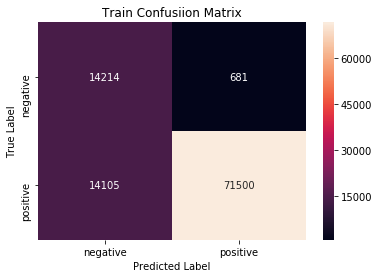

In [32]:
trainconfusionmatrix(Model_Tfidf,X_Train_Tfidf,Y_train)

Confusion Matrix for Test set


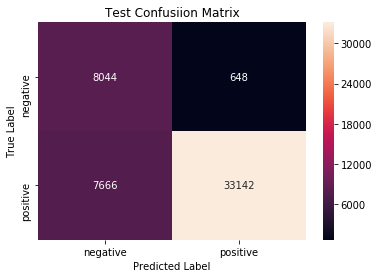

In [33]:
testconfusionmatrix(Model_Tfidf,X_Test_Tfidf,Y_test)

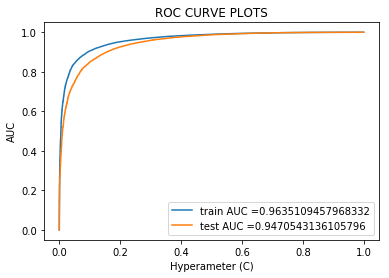

In [34]:
plot_auc_roc(Model_Tfidf,X_Train_Tfidf,X_Test_Tfidf,Y_train,Y_test)

In [35]:
print("Classification Report: \n")
y_pred=Model_Tfidf.predict(X_Test_Tfidf)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.51      0.93      0.66      8692
           1       0.98      0.81      0.89     40808

   micro avg       0.83      0.83      0.83     49500
   macro avg       0.75      0.87      0.77     49500
weighted avg       0.90      0.83      0.85     49500



In [36]:
show_30_informative_feature(vectorizer_tfidf,Model_Tfidf)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		6.398	addict                        		-8.666	aw
2.		7.030	amaz                          		-4.353	bare
3.		5.944	awesom                        		-4.465	bewar
4.		5.792	beat                          		-6.507	bland
5.		4.120	beauti                        		-4.733	cancel
6.		7.024	best                          		-9.024	disappoint
7.		4.659	complaint                     		-6.022	disgust
8.		8.489	delici                        		-4.433	earth
9.		4.560	easi                          		-5.182	gross
10.		7.182	excel                         		-7.371	horribl
11.		5.105	fantast                       		-4.307	money
12.		4.673	favorit                       		-5.133	poor
13.		5.131	glad                          		-5.292	refund
14.		6.400	great                         		-7.271	return
15.		4.215	happi               

## Word To Vector

In [15]:
list_of_Train_sent=[]
list_of_Test_sent=[]

for sent in X_train:
    list_of_Train_sent.append(sent.split())
    
for sent in X_test:
    list_of_Test_sent.append(sent.split())

In [16]:
model=Word2Vec(list_of_Train_sent,min_count=5,size=50, workers=4)

## Average Word To Vector

In [17]:
import numpy as np

Train_vectors = []
for sent in list_of_Train_sent:
    sent_vec = np.zeros(50)
    cnt_words = 0
    for word in sent:
        try:
            vec = model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words!=0:    
        sent_vec /= cnt_words
    Train_vectors.append(sent_vec)
Train_vectors = np.nan_to_num(Train_vectors)

In [18]:
import numpy as np

Test_vectors=[]
for sent in list_of_Test_sent:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        try:
            vec=model.wv[word]
            sent_vec+=vec
            cnt_words+=1
        except:
            pass
    if cnt_words!=0:
        sent_vec/=cnt_words
    Test_vectors.append(sent_vec)
Test_vectors=np.nan_to_num(Test_vectors)    

In [19]:
print("Shape of Test Vectors : ",Test_vectors.shape)

Shape of Test Vectors :  (49500, 50)


In [20]:
X_Train_Awv=Train_vectors
X_Test_Awv=Test_vectors

In [21]:
print(X_Train_Awv.shape, Y_train.shape)
print(X_Test_Awv.shape, Y_test.shape)

(100500, 50) (100500,)
(49500, 50) (49500,)


## Taking L1 as a Regularisation Parameter

### Finding the best value Of hyperparameter (C or 1/Lambda) 

In [23]:
gsv=Grid_SearchCV(X_Train_Awv,Y_train,"l1")

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed: 52.6min finished


Best HyperParameter:  {'C': 1, 'penalty': 'l1'}
Best Accuracy: 90.46%


### Error Plot

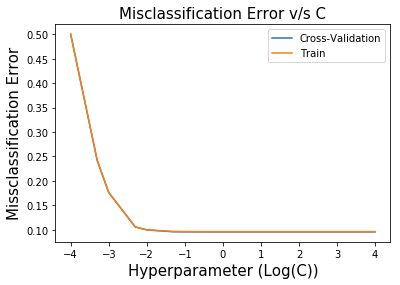

In [24]:
plot(gsv)

### Training Model 

In [25]:
Best_Param=gsv.best_params_
C=Best_Param['C']
Penalty = Best_Param['penalty']

Model_Awv=LogisticRegression(C=C,penalty=Penalty,class_weight='balanced')
Model_Awv.fit(X_Train_Awv,Y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


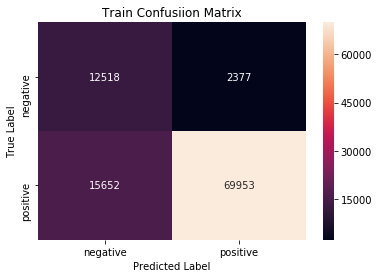

In [26]:
trainconfusionmatrix(Model_Awv,X_Train_Awv,Y_train)

Confusion Matrix for Train set


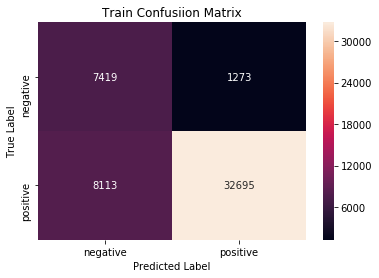

In [27]:
trainconfusionmatrix(Model_Awv,X_Test_Awv,Y_test)

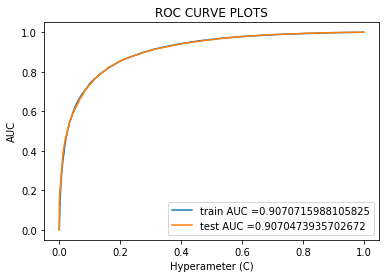

In [28]:
plot_auc_roc(Model_Awv,X_Train_Awv,X_Test_Awv,Y_train,Y_test)

In [29]:
print("Classification Report: \n")
y_pred=Model_Awv.predict(X_Test_Awv)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.48      0.85      0.61      8692
           1       0.96      0.80      0.87     40808

   micro avg       0.81      0.81      0.81     49500
   macro avg       0.72      0.83      0.74     49500
weighted avg       0.88      0.81      0.83     49500



## Taking L2 as a Regularisation Parameter

### Finding the best value Of hyperparameter (C or 1/Lambda)

In [22]:
gsv=Grid_SearchCV(X_Train_Awv,Y_train,"l2")

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:  3.2min finished


Best HyperParameter:  {'C': 0.05, 'penalty': 'l2'}
Best Accuracy: 90.49%


### Error Plot

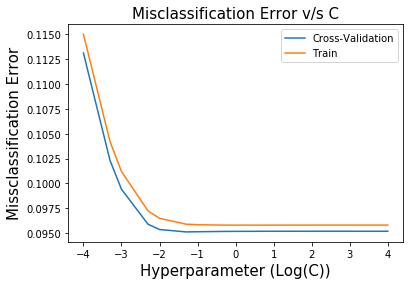

In [23]:
plot(gsv)

### Training the model

In [24]:
Best_Param=gsv.best_params_
C=Best_Param['C']
Penalty = Best_Param['penalty']

Model_Awv=LogisticRegression(C=C,penalty=Penalty,class_weight='balanced')
Model_Awv.fit(X_Train_Awv,Y_train)

LogisticRegression(C=0.05, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


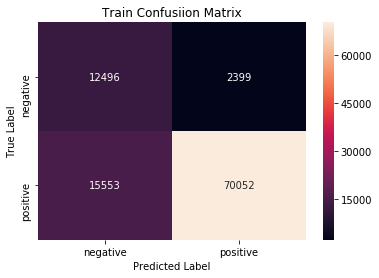

In [25]:
trainconfusionmatrix(Model_Awv,X_Train_Awv,Y_train)

Confusion Matrix for Train set


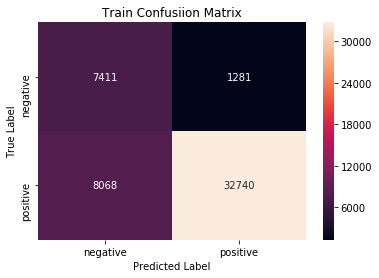

In [26]:
trainconfusionmatrix(Model_Awv,X_Test_Awv,Y_test)

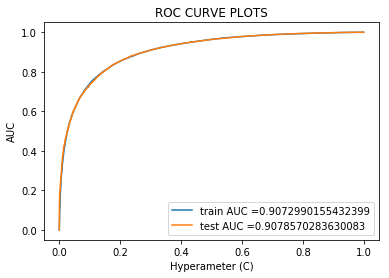

In [27]:
plot_auc_roc(Model_Awv,X_Train_Awv,X_Test_Awv,Y_train,Y_test)

In [28]:
print("Classification Report: \n")
y_pred=Model_Awv.predict(X_Test_Awv)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.48      0.85      0.61      8692
           1       0.96      0.80      0.88     40808

   micro avg       0.81      0.81      0.81     49500
   macro avg       0.72      0.83      0.74     49500
weighted avg       0.88      0.81      0.83     49500



## TF-IDF Word To Vector

In [33]:
TFIDF_Feature=vectorizer_tfidf.get_feature_names()
print(len(TFIDF_Feature))
print(TFIDF_Feature[0:20])

37994
['aaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaagghh', 'aaaaaaahhhhhh', 'aaaaaah', 'aaaaaahhhhhyaaaaaa', 'aaaaaand', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaaawsom', 'aaaah', 'aaaahhhhhh', 'aaaallll', 'aaaand', 'aaah', 'aachen', 'aacur', 'aad', 'aadult']


In [34]:
from tqdm import tqdm
Train_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Train_sent):
    sent_vec=np.zeros(50)
    weight=0
    for word in sent:
        try :
            w2v_vec=model.wv[word]
            tfidf_vec=X_Train_Tfidf[row,TFIDF_Feature.index(word)]
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf_vec
            
        except :
            pass
    if weight!=0:
        sent_vec/=weight
    Train_TFIDF_W2V_Vectors.append(sent_vec) 
    row+=1

100%|████████████████████████████████| 100500/100500 [1:04:56<00:00, 25.79it/s]


In [35]:
Test_TFIDF_W2V_Vectors=[]
row=0
for sent in tqdm(list_of_Test_sent):
    sent_vec=np.zeros(50)
    weight=0
    
    for word in sent:
        try:
            w2v_vec=model.wv[word]
            tfidf_vec=X_Test_Tfidf(row,TFIDF_Feature.index(word))
            sent_vec+=(w2v_vec*tfidf_vec)
            weight+=tfidf
          
        except :
            pass
    
    if weight!=0:
        sent_vec/=weight
    Test_TFIDF_W2V_Vectors.append(sent_vec)    
    row+=1

100%|████████████████████████████████████| 49500/49500 [24:01<00:00, 34.33it/s]


In [36]:
Train_TFIDF_W2V_Vectors = np.nan_to_num(Train_TFIDF_W2V_Vectors)
Test_TFIDF_W2V_Vectors = np.nan_to_num(Test_TFIDF_W2V_Vectors)

In [37]:
X_Train_TfidfW2v=Train_TFIDF_W2V_Vectors
X_Test_TfidfW2v=Test_TFIDF_W2V_Vectors

In [38]:
print(X_Train_TfidfW2v.shape, Y_train.shape)
print(X_Test_TfidfW2v.shape, Y_test.shape)

(100500, 50) (100500,)
(49500, 50) (49500,)


## Taking L1 as a Regularisation Parameter

### Finding the best value Of hyperparameter (C or 1/Lambda) 

In [39]:
gsv=Grid_SearchCV(X_Train_TfidfW2v,Y_train,"l1")

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed: 26.1min finished


Best HyperParameter:  {'C': 0.1, 'penalty': 'l1'}
Best Accuracy: 87.85%


### Error Plot

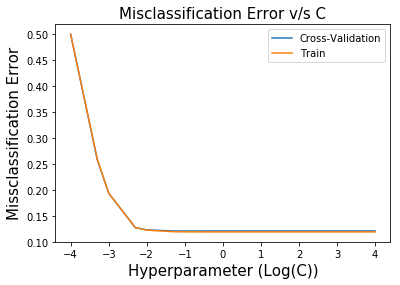

In [40]:
plot(gsv)

### Training Model

In [41]:
Best_Param=gsv.best_params_
C=Best_Param['C']
Penalty = Best_Param['penalty']

Model_TfidfW2v=LogisticRegression(C=C,penalty=Penalty,class_weight='balanced')
Model_TfidfW2v.fit(X_Train_TfidfW2v,Y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


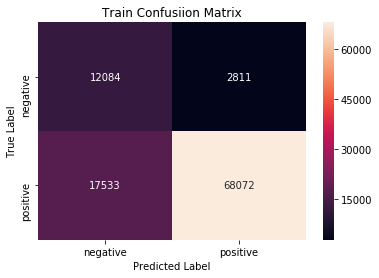

In [42]:
trainconfusionmatrix(Model_TfidfW2v,X_Train_TfidfW2v,Y_train)

Confusion Matrix for Test set


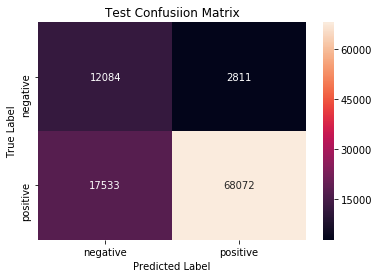

In [43]:
testconfusionmatrix(Model_TfidfW2v,X_Train_TfidfW2v,Y_train)

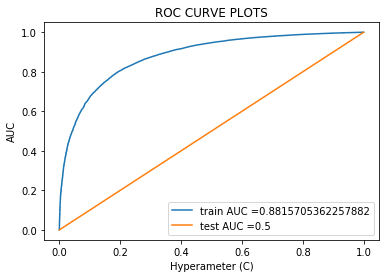

In [44]:
plot_auc_roc(Model_TfidfW2v,X_Train_TfidfW2v,X_Test_TfidfW2v,Y_train,Y_test)

In [45]:
print("Classification Report: \n")
y_pred=Model_TfidfW2v.predict(X_Test_TfidfW2v)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.18      1.00      0.30      8692
           1       0.00      0.00      0.00     40808

   micro avg       0.18      0.18      0.18     49500
   macro avg       0.09      0.50      0.15     49500
weighted avg       0.03      0.18      0.05     49500



## Taking L2 as a Regularisation Parameter

### Finding the best value Of hyperparameter (C or 1/Lambda)

In [46]:
gsv=Grid_SearchCV(X_Train_TfidfW2v,Y_train,"l1")

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed: 27.0min finished


Best HyperParameter:  {'C': 0.1, 'penalty': 'l1'}
Best Accuracy: 87.85%


### Error Plot

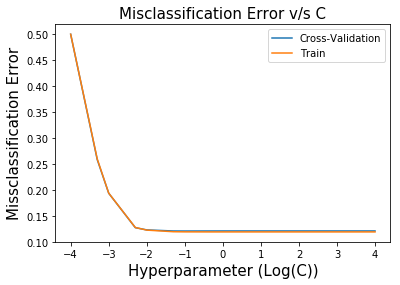

In [47]:
plot(gsv)

### Training the model

In [48]:
Best_Param=gsv.best_params_
C=Best_Param['C']
Penalty = Best_Param['penalty']

Model_TfidfW2v=LogisticRegression(C=C,penalty=Penalty,class_weight='balanced')
Model_TfidfW2v.fit(X_Train_TfidfW2v,Y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

### Evaluating the performance of model

Confusion Matrix for Train set


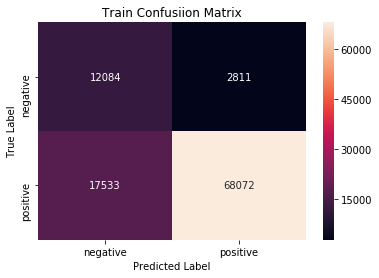

In [49]:
trainconfusionmatrix(Model_TfidfW2v,X_Train_TfidfW2v,Y_train)

Confusion Matrix for Test set


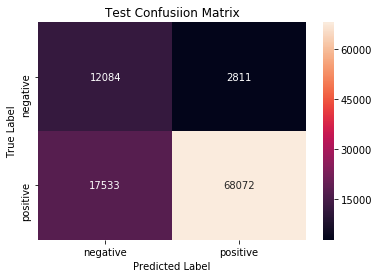

In [50]:
testconfusionmatrix(Model_TfidfW2v,X_Train_TfidfW2v,Y_train)

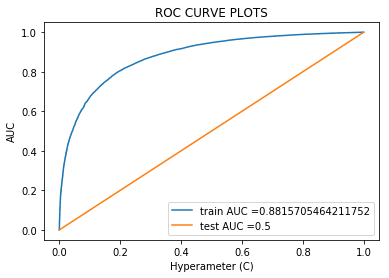

In [51]:
plot_auc_roc(Model_TfidfW2v,X_Train_TfidfW2v,X_Test_TfidfW2v,Y_train,Y_test)

In [52]:
print("Classification Report: \n")
y_pred=Model_TfidfW2v.predict(X_Test_TfidfW2v)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.18      1.00      0.30      8692
           1       0.00      0.00      0.00     40808

   micro avg       0.18      0.18      0.18     49500
   macro avg       0.09      0.50      0.15     49500
weighted avg       0.03      0.18      0.05     49500



## Pertubation Test On BOW Vectorizer and Regularisation Parameter L2

In [62]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(Model_Bow.coef_[0])[2]
print(weights1[:50])

[ 1.13345591  0.02002588  0.00200432  0.03735237  0.00537296  0.00278505
 -0.05079941  0.00931602  0.00537296  0.13805403  0.03798705  0.0069488
  0.03927589  0.01479231  0.02671619  0.0565606  -0.40902605  0.03473881
  0.00330004  0.07520482 -0.05522391  0.06312428  0.02666827  0.032443
  0.04260278 -0.03394333  0.04648075  0.00561827  0.28007135  0.18782385
 -0.34749559  0.05698905  0.00788936 -1.170488    0.52939662  0.20041705
 -0.07370247 -0.23254724  0.23001907  0.09660233  0.3921331   0.35992047
 -0.27294236  0.17301799  0.80156947  0.07930274 -0.76391136  0.07604107
  0.0629005   0.02145765]


In [63]:
X_train_t = X_train_bow
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(X_train_t)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(X_train_t)

#Introducing random noise to non-zero datapoints
X_train_t[a,b] = epsilon + X_train_t[a,b]

In [64]:
Model_Pert= LogisticRegression(C=C, penalty= 'l2',class_weight='balanced')
Model_Pert.fit(X_train_t,Y_train)
y_pred = Model_Pert.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, y_pred)*100))
print("Non Zero weights:",np.count_nonzero(Model_Pert.coef_))

Accuracy on test set: 87.933%
Non Zero weights: 37994


In [65]:
#Weights after adding random noise
weights2 = find(Model_Pert.coef_[0])[2]
print(weights2[:50])

[ 1.13328701  0.02007606  0.00200724  0.03734596  0.00538038  0.00278589
 -0.05092452  0.00931236  0.00538486  0.13790361  0.03810089  0.00694868
  0.03934439  0.0148218   0.02677143  0.0565591  -0.40895739  0.03471803
  0.00329922  0.07520774 -0.05585209  0.06320037  0.02665189  0.03241966
  0.04256979 -0.0338506   0.04647984  0.00561043  0.28022148  0.18792607
 -0.34781192  0.05681231  0.00787586 -1.17053264  0.52951101  0.20055738
 -0.07368803 -0.23281588  0.22997003  0.09659027  0.39222921  0.35980129
 -0.27276686  0.1729645   0.80172465  0.07946077 -0.76348883  0.07607611
  0.06293845  0.02146781]


In [66]:
weights_diff = (abs(weights1 - weights2)/weights1) * 100

In [67]:
print(weights_diff[np.where(weights_diff > 30)].size)

3


### Showing How Sparsity increases as we decrease C or increase Lambada(1/C)  When L1 Regularisation is used

In [55]:
Model_Sparse= LogisticRegression(C= 1000, penalty= 'l1',class_weight='balanced')
Model_Sparse.fit(X_train_bow,Y_train)
y_pred = Model_Sparse.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(Model_Sparse.coef_))

Accuracy on test set: 85.586%
F1-Score on test set: 0.910
Non Zero weights: 18732


In [56]:
Model_Sparse= LogisticRegression(C= 100, penalty= 'l1',class_weight='balanced')
Model_Sparse.fit(X_train_bow,Y_train)
y_pred = Model_Sparse.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(Model_Sparse.coef_))

Accuracy on test set: 86.901%
F1-Score on test set: 0.918
Non Zero weights: 14916


In [57]:
Model_Sparse= LogisticRegression(C= 10, penalty= 'l1',class_weight='balanced')
Model_Sparse.fit(X_train_bow,Y_train)
y_pred = Model_Sparse.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(Model_Sparse.coef_))

Accuracy on test set: 88.222%
F1-Score on test set: 0.926
Non Zero weights: 7780


In [58]:
Model_Sparse= LogisticRegression(C= 1, penalty= 'l1',class_weight='balanced')
Model_Sparse.fit(X_train_bow,Y_train)
y_pred = Model_Sparse.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(Model_Sparse.coef_))

Accuracy on test set: 87.299%
F1-Score on test set: 0.919
Non Zero weights: 1931


In [59]:
Model_Sparse= LogisticRegression(C= 0.1, penalty= 'l1',class_weight='balanced')
Model_Sparse.fit(X_train_bow,Y_train)
y_pred = Model_Sparse.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(Model_Sparse.coef_))

Accuracy on test set: 83.978%
F1-Score on test set: 0.896
Non Zero weights: 409


In [60]:
Model_Sparse= LogisticRegression(C= 0.01, penalty= 'l1')
Model_Sparse.fit(X_train_bow,Y_train)
y_pred = Model_Sparse.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(Model_Sparse.coef_))

Accuracy on test set: 82.828%
F1-Score on test set: 0.906
Non Zero weights: 21


In [61]:
Model_Sparse= LogisticRegression(C= 0.001, penalty= 'l1',class_weight='balanced')
Model_Sparse.fit(X_train_bow,Y_train)
y_pred = Model_Sparse.predict(X_test_bow)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(Y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(Y_test, y_pred)))
print("Non Zero weights:",np.count_nonzero(Model_Sparse.coef_))

Accuracy on test set: 38.505%
F1-Score on test set: 0.423
Non Zero weights: 1


1. Decrease in value of C decrease the non of non zeros weight decrease , which means it is increasing the sparsity(No of Zeros) 

### Addition of another column length

In [18]:
Train_len=[]
Test_len=[]
for i in X_train:
    Train_len.append(len(i))
    
for i in X_test:
    Test_len.append(len(i))

In [19]:
Train_len=np.array(Train_len)
Test_len=np.array(Test_len)

In [20]:
Train_len=Train_len[:,np.newaxis]
Test_len=Test_len[:,np.newaxis]

#### Bag Of Word Vectorizer

In [21]:
X_Train_BOW=X_train_bow.todense()

In [22]:
X_Train_New=np.append(X_Train_BOW,Train_len,axis=1)

In [23]:
from scipy.sparse import csr_matrix
X_Train_New= csr_matrix(X_Train_New)

In [24]:
print("Shape of Train Data Before Adding length column ")
print(X_train_bow.shape)

print("\nShape of Train Data After Adding length column ")
print(X_Train_New.shape)

Shape of Train Data Before Adding length column 
(100500, 37994)

Shape of Train Data After Adding length column 
(100500, 37995)


#### Finding the best value Of hyperparameter (C or 1/lambda) 

In [29]:
gsv=Grid_SearchCV(X_Train_New,Y_train,"l1")

print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed: 110.4min finished


Best HyperParameter:  {'C': 1, 'penalty': 'l1'}
Best Accuracy: 93.26%


#### Error Plot

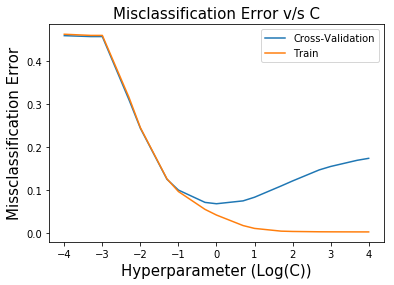

In [30]:
plot(gsv)

#### Training the Model

In [25]:
X_Test_Bow=X_test_bow.todense()

In [26]:
X_Test_New=np.append(X_Test_Bow,Test_len,axis=1)

In [27]:
from scipy.sparse import csr_matrix
X_Test_New= csr_matrix(X_Test_New)

In [31]:
Best_Param=gsv.best_params_
C=Best_Param['C']
Penalty = Best_Param['penalty']

In [32]:
Model_LBow = LogisticRegression(C=C,penalty = Penalty,class_weight='balanced')
Model_LBow.fit(X_Train_New,Y_train)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

#### Evaluating the performance of the model

Confusion Matrix for Train set


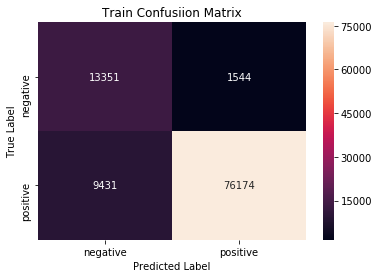

In [33]:
trainconfusionmatrix(Model_LBow,X_Train_New,Y_train)

Confusion Matrix for Test set


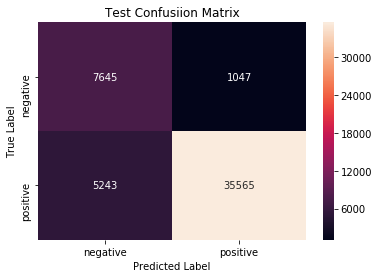

In [34]:
testconfusionmatrix(Model_LBow,X_Test_New,Y_test)

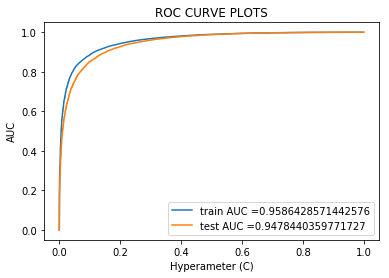

In [35]:
plot_auc_roc(Model_LBow,X_Train_New,X_Test_New,Y_train,Y_test)

In [36]:
print("Classification Report: \n")
y_pred=Model_LBow.predict(X_Test_New)

print(classification_report(Y_test, y_pred))

Classification Report: 

              precision    recall  f1-score   support

           0       0.59      0.88      0.71      8692
           1       0.97      0.87      0.92     40808

   micro avg       0.87      0.87      0.87     49500
   macro avg       0.78      0.88      0.81     49500
weighted avg       0.90      0.87      0.88     49500



### Displaying 30 most informative features

In [37]:
show_30_informative_feature(vectorizer,Model_LBow)

S.N                 Positive                                               Negative            
__________________________________________________________________________________________
1.		10.165	addict                        		-13.051	aw
2.		9.406	amaz                          		-9.123	bland
3.		8.438	awesom                        		-10.127	cancel
4.		10.038	beat                          		-10.607	concept
5.		7.003	beauti                        		-7.860	deceiv
6.		7.925	best                          		-9.884	decept
7.		7.292	complaint                     		-10.151	disappoint
8.		10.010	delici                        		-11.124	disgust
9.		11.888	downsid                       		-7.976	drinkabl
10.		8.479	excel                         		-8.112	fail
11.		6.976	fabul                         		-10.002	flavorless
12.		7.065	fantast                       		-8.534	gross
13.		6.811	glad                          		-10.867	horribl
14.		6.903	great                         		-10.231	ined
15.		7.23

#### 1.Report On Different Vectorizer Method and Regularisation Parameter L1

In [1]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Hyperparameter(C or 1/Lambda)","Train AUC","Test AUC","F1-Score"]

x.add_row(["BOW",5,0.96,0.94,0.91])
x.add_row(["TF-IDF",1,0.95,0.94,0.85])
x.add_row(["Avg W2V",1,0.90,0.90,0.83])
x.add_row(["TF-IDF W2V",0.1,0.88,0.50,0.05])

print(x)

+------------+-------------------------------+-----------+----------+----------+
| Vectorizer | Hyperparameter(C or 1/Lambda) | Train AUC | Test AUC | F1-Score |
+------------+-------------------------------+-----------+----------+----------+
|    BOW     |               5               |    0.96   |   0.94   |   0.91   |
|   TF-IDF   |               1               |    0.95   |   0.94   |   0.85   |
|  Avg W2V   |               1               |    0.9    |   0.9    |   0.83   |
| TF-IDF W2V |              0.1              |    0.88   |   0.5    |   0.05   |
+------------+-------------------------------+-----------+----------+----------+


#### 2.Report On Different Vectorizer Method and Regularisation Parameter L2

In [2]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Hyperparameter(C or 1/Lambda)","Train AUC","Test AUC","F1-Score"]

x.add_row(["BOW",5,0.96,0.94,0.89])
x.add_row(["TF-IDF",1,0.96,0.94,0.85])
x.add_row(["Avg W2V",0.05,0.90,0.90,0.83])
x.add_row(["TF-IDF W2V",0.1,0.88,0.50,0.05])

print(x)

+------------+-------------------------------+-----------+----------+----------+
| Vectorizer | Hyperparameter(C or 1/Lambda) | Train AUC | Test AUC | F1-Score |
+------------+-------------------------------+-----------+----------+----------+
|    BOW     |               5               |    0.96   |   0.94   |   0.89   |
|   TF-IDF   |               1               |    0.96   |   0.94   |   0.85   |
|  Avg W2V   |              0.05             |    0.9    |   0.9    |   0.83   |
| TF-IDF W2V |              0.1              |    0.88   |   0.5    |   0.05   |
+------------+-------------------------------+-----------+----------+----------+


#### 3.Report On Different Vectorizer Method After Addition Of Length as another Column

In [3]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Hyperparameter(C or 1/Lambda)","Train AUC","Test AUC","F1-Score"]

x.add_row(["BOW",1,0.95,0.94,0.88])


print(x)

+------------+-------------------------------+-----------+----------+----------+
| Vectorizer | Hyperparameter(C or 1/Lambda) | Train AUC | Test AUC | F1-Score |
+------------+-------------------------------+-----------+----------+----------+
|    BOW     |               1               |    0.95   |   0.94   |   0.88   |
+------------+-------------------------------+-----------+----------+----------+


#### 4. I have taken considerable amount of data but it did not take long time in execution .
#### 5. Since data is unbalanced , i did time based splitting and used roc_auc metric as scoring parameter in GridsearchCV .
#### 6. After adding Length as another column , there is no any improvement.
#### 7. TF-IDF W2V is not performing well .